In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tflow
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.applications import ResNet50
import cv2
import os

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))     # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [5]:
!ls /content/drive/MyDrive/

'archive (3)'	  'Colab Notebooks'		     'Untitled document.gdoc'
 Car_Brand_Logos   CS201_Assignment1_210001053.gdoc  'Untitled folder'
 cenagage	   sem4				     'Untitled spreadsheet.gsheet'
 chest_xray	  'Untitled document (1).gdoc'
 chest_xray.zip   'Untitled document (2).gdoc'


In [6]:
train = get_data('/content/drive/MyDrive/chest_xray/train')
test = get_data('/content/drive/MyDrive/chest_xray/test')
val = get_data('/content/drive/MyDrive/chest_xray/val')

<ipython-input-4-224b011a10db>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [7]:
pneumonia = os.listdir("/content/drive/MyDrive/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/content/drive/MyDrive/chest_xray/train/PNEUMONIA"

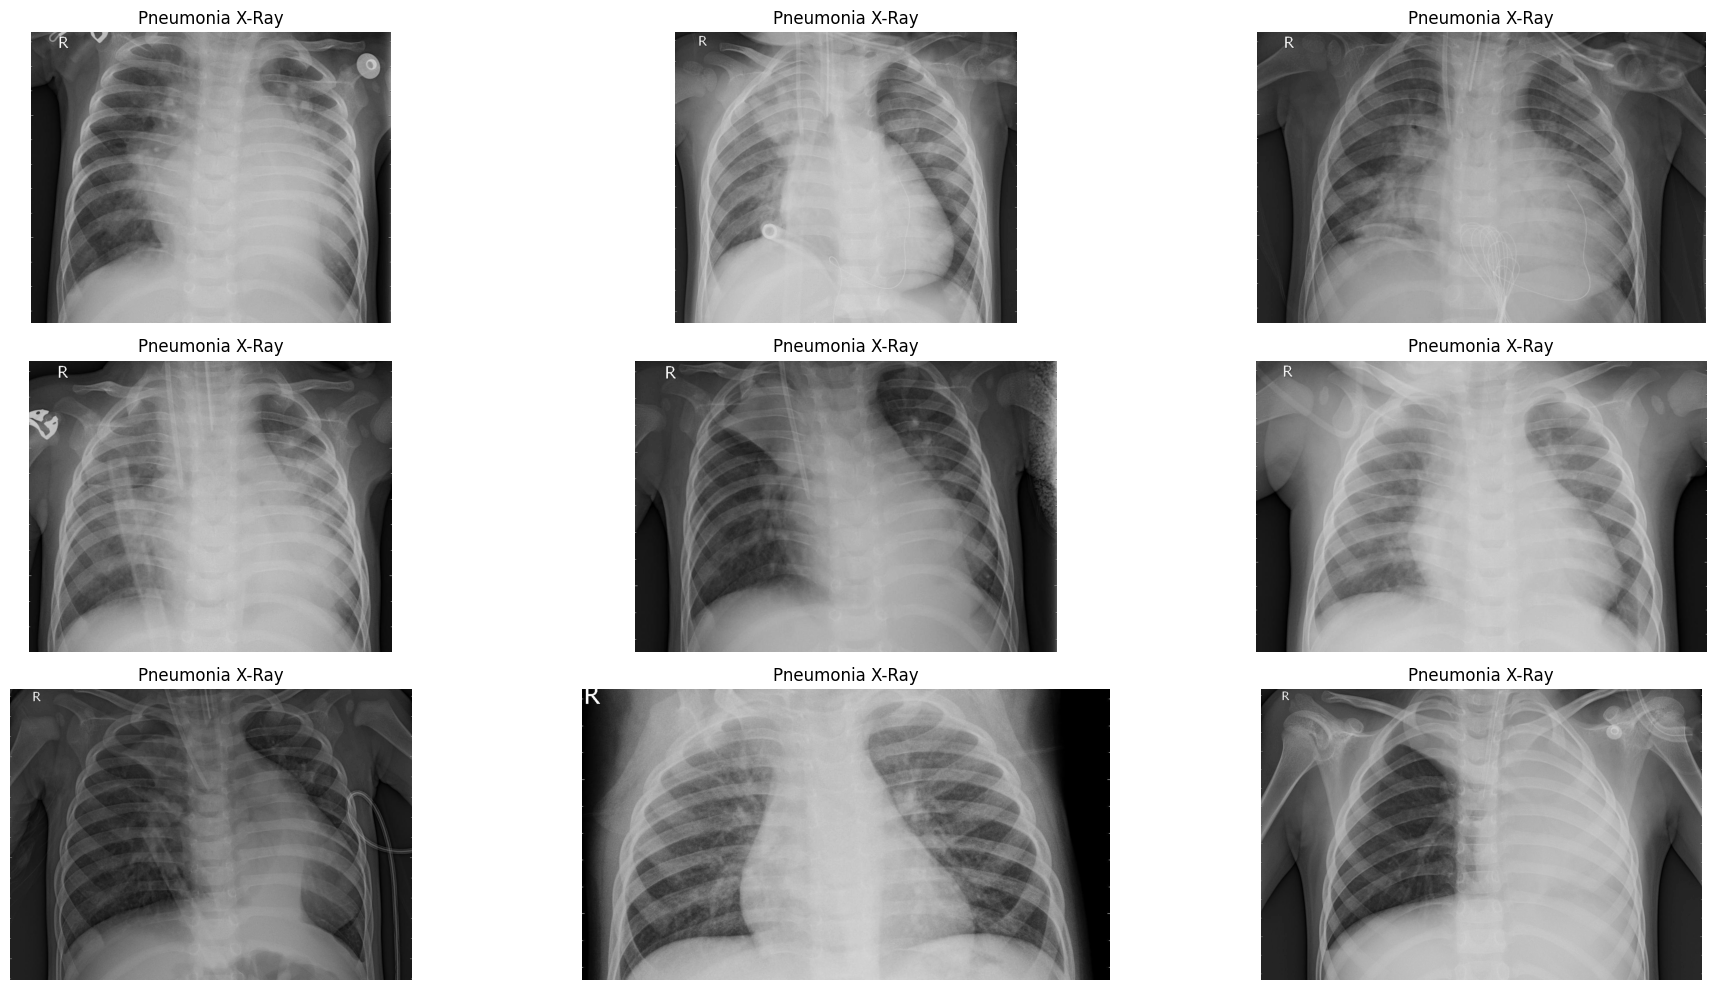

In [8]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray")
plt.tight_layout()

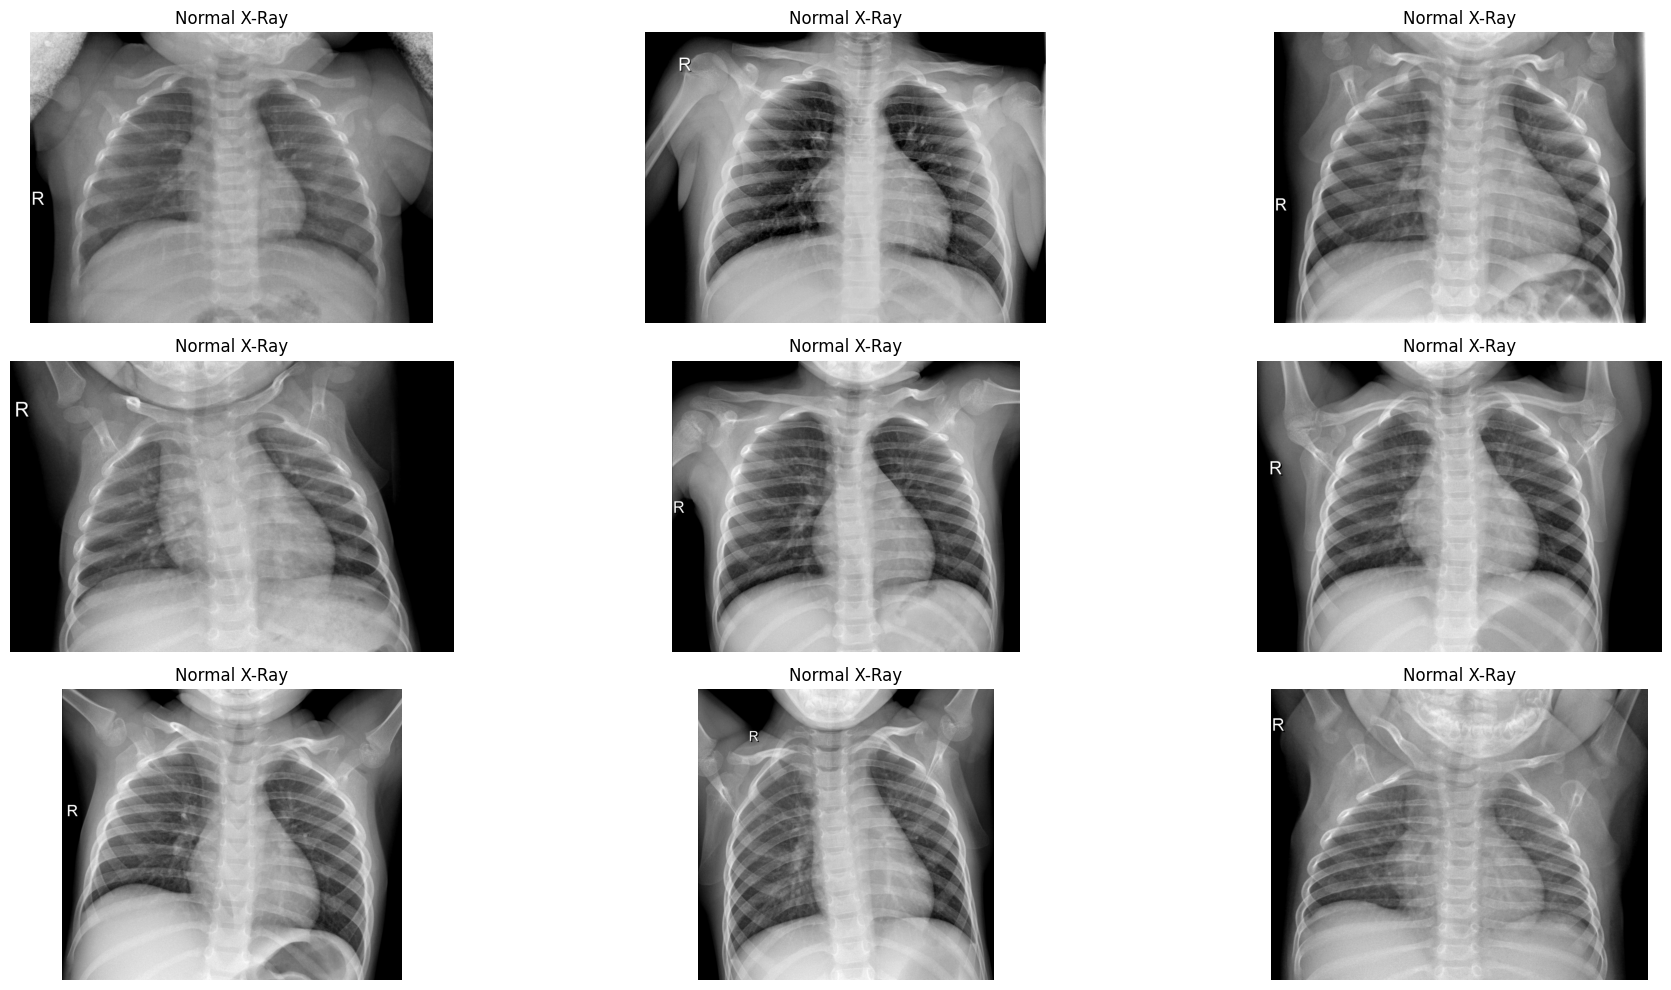

In [9]:
normal = os.listdir("/content/drive/MyDrive/chest_xray/train/NORMAL")
normal_dir = "/content/drive/MyDrive/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray")

plt.tight_layout()

Text(0.5, 1.0, 'NORMAL')

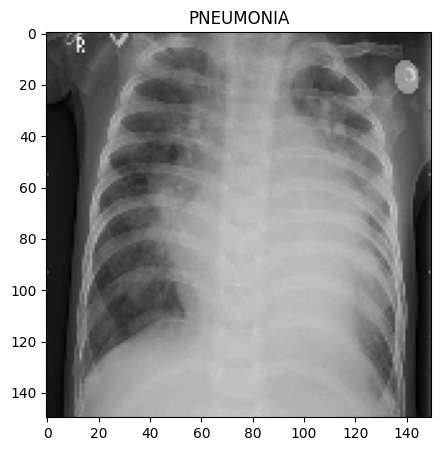

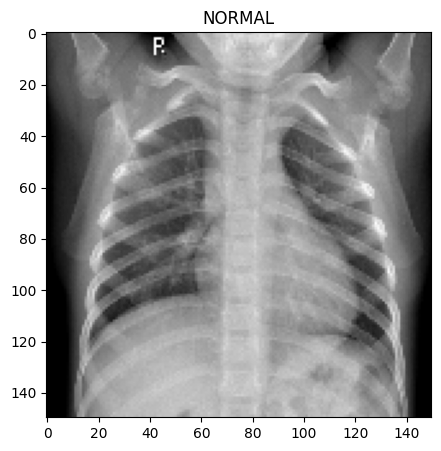

In [10]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [11]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [12]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [14]:
from PIL import Image

# Convert single-channel images to three channels (grayscale to RGB)
x_train_rgb = np.repeat(x_train, 3, -1)
x_val_rgb = np.repeat(x_val, 3, -1)
x_test_rgb = np.repeat(x_test, 3, -1)


In [15]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import InceptionV3

# Load InceptionV3 model without the top (fully connected) layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3),pooling='avg',classes=2)

# Create a new input layer for single-channel images
single_channel_input = Input(shape=(224, 224, 1))

# Create a custom Conv2D layer for single-channel input
custom_conv_layer = Conv2D(3, (3, 3), padding='same', activation='relu')(single_channel_input)

# Concatenate the custom layer with the original InceptionV3 model
new_input = Model(inputs=single_channel_input, outputs=custom_conv_layer)
new_input_model = Model(inputs=new_input.input, outputs=base_model(new_input.output))

# Add your custom dense layers on top of the modified InceptionV3
model = Sequential()
model.add(new_input_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the modified model
model.summary()


87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2048)              21802814  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 22852415 (87.18 MB)
Trainable params: 22817983 (87.04 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.00001)


In [17]:
history = model.fit(datagen.flow(x_train_rgb,y_train, batch_size = 32) ,epochs = 30 , validation_data = datagen.flow(x_val_rgb, y_val) ,callbacks = [learning_rate_reduction])


Epoch 1/30
163/163 [==============================] - 79s 225ms/step - loss: 0.2395 - accuracy: 0.9072 - val_loss: 2.5230 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 34s 210ms/step - loss: 0.1790 - accuracy: 0.9317 - val_loss: 3.2772 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9442
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 33s 203ms/step - loss: 0.1474 - accuracy: 0.9442 - val_loss: 1.0765 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 34s 209ms/step - loss: 0.1165 - accuracy: 0.9569 - val_loss: 2.1722 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9674
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

In [18]:
print("Loss of the model is - " , model.evaluate(x_test_rgb,y_test)[0])
print("Accuracy of the model is - " ,model.evaluate(x_test_rgb,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 31ms/step - loss: 0.1551 - accuracy: 0.9471
Loss of the model is -  0.15509440004825592
20/20 [==============================] - 1s 31ms/step - loss: 0.1551 - accuracy: 0.9471
Accuracy of the model is -  94.71153616905212 %
